In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fsd_path_planning.demo.streamlit_demo.common import get_cones_for_configuration
import numpy as np
import matplotlib.pyplot as plt
from fsd_path_planning.utils.math_utils import rotate, angle_from_2d_vector

In [180]:
position, direction, cones = get_cones_for_configuration("Hairpin", do_shuffle=True)

from pathlib import Path
position, direction, cones = eval(Path('/home/papalotis/repos/fsd-path-planning/example_data.txt').read_text())

cones = [np.array(cone).reshape(-1,2) for cone in cones]

In [181]:
cones_together = np.row_stack(cones)

idxs = np.random.default_rng(0).random(len(cones_together)).argsort()


cones_together = cones_together[idxs]

(-5.2417541475, 68.80199579750001, -30.294162, 39.418338000000006)

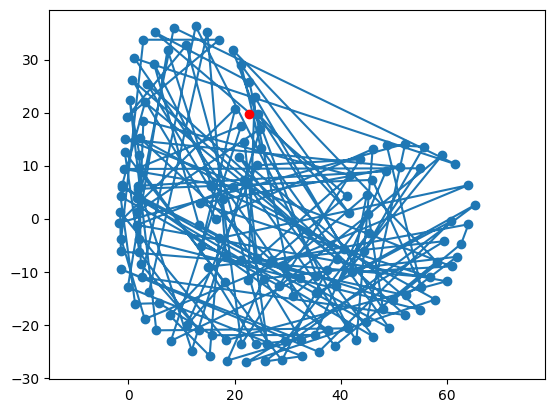

In [182]:
plt.plot(*cones_together.T, "o-")
plt.plot(*position, "ro")
plt.axis("equal")

(-23.550890075497847,
 50.524649098518125,
 -35.36204402851401,
 38.66576366333371)

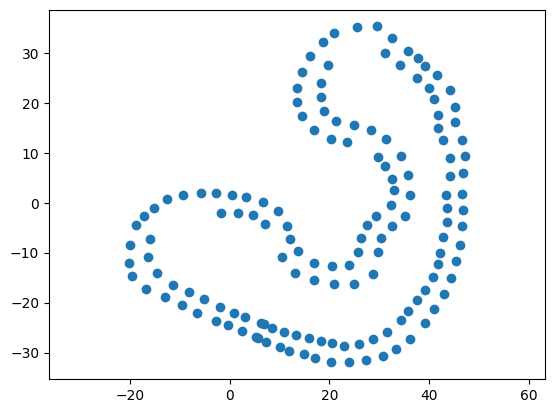

In [183]:
cones_relative = rotate(cones_together - position, -angle_from_2d_vector(direction))

plt.plot(*cones_relative.T, "o")
plt.axis("equal")

In [184]:
from fsd_path_planning.utils.cone_types import ConeTypes

cone_type = ConeTypes.RIGHT

False True
111


(-23.550890075497847,
 50.524649098518125,
 -35.36204402851401,
 38.66576366333371)

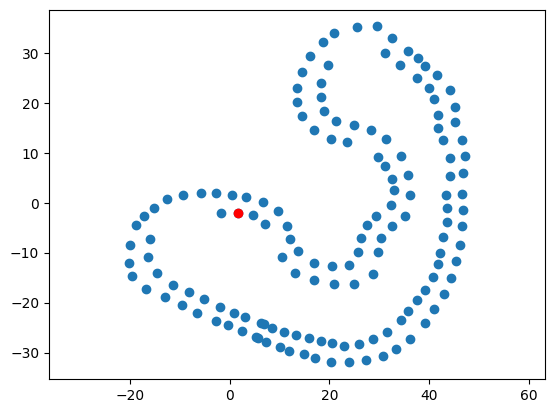

In [185]:
distance = np.linalg.norm(cones_relative, axis=1)
angle = angle_from_2d_vector(cones_relative)

angle_in_range_left = (angle > 0) & (angle < np.pi / 2)
angle_in_range_right = (angle < 0) & (angle > -np.pi / 2)

mask_angle_is_in_range = angle_in_range_left if cone_type == ConeTypes.LEFT else angle_in_range_right

print(mask_angle_is_in_range is angle_in_range_left, mask_angle_is_in_range is angle_in_range_right)

distance[~mask_angle_is_in_range] = np.inf

closest_cone_idx = np.argmin(distance)
print(closest_cone_idx)

plt.plot(*cones_relative.T, "o")
plt.plot(*cones_relative[closest_cone_idx], "ro")
plt.axis("equal")

(-23.550890075497847,
 50.524649098518125,
 -35.36204402851401,
 38.66576366333371)

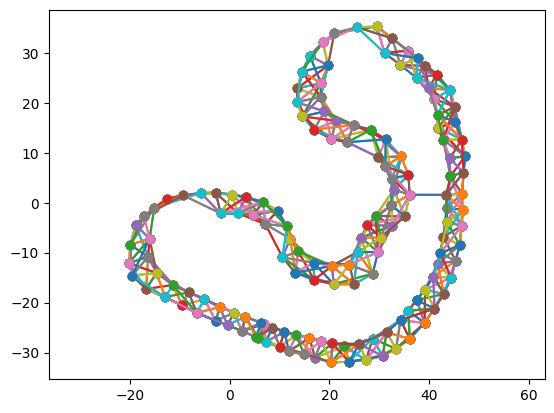

In [220]:
from fsd_path_planning.sorting_cones.trace_sorter.adjacency_matrix import create_adjacency_matrix

max_dist = 10

adj, _ = create_adjacency_matrix(cones_relative, n_neighbors=8, start_idx=closest_cone_idx, max_dist=max_dist)

for x in np.argwhere(adj):
    plt.plot(*cones_relative[x].T, "o-")


plt.axis("equal")

In [221]:
from fsd_path_planning.sorting_cones.trace_sorter.end_configurations import find_all_end_configurations

In [222]:
from fsd_path_planning.utils.cone_types import ConeTypes

# %timeit -n10 -r10 find_all_end_configurations(cones_relative, cone_type, closest_cone_idx, adj, 10, np.deg2rad(40), np.deg2rad(70), np.zeros(0, int), np.array([1,.0]), store_all_end_configurations=False)

configs, _ = find_all_end_configurations(cones_relative, cone_type, closest_cone_idx, adj, 10, np.deg2rad(40), np.deg2rad(70), np.zeros(0, int),np.array([1,.0]), store_all_end_configurations=False)
print(len(configs))

3805


In [231]:
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations


# %timeit -r10 -n10 cost_configurations(cones_relative, configs, cone_type, np.array([1.0, 0]), return_individual_costs=True)
costs_split = cost_configurations(cones_relative, configs, cone_type, np.array([1.0, 0]), return_individual_costs=True)
costs = costs_split.sum(axis=1)



In [232]:

# for ci in costs_split[:,-1].argsort()[:10]:
#     c = configs[ci]
#     c = c[c != -1]
#     plt.plot(*cones_relative.T, "o")
#     plt.plot(*cones_relative[c].T, "o-")
#     plt.axis("equal")
#     plt.title(costs_split[ci,-1])
#     plt.show()

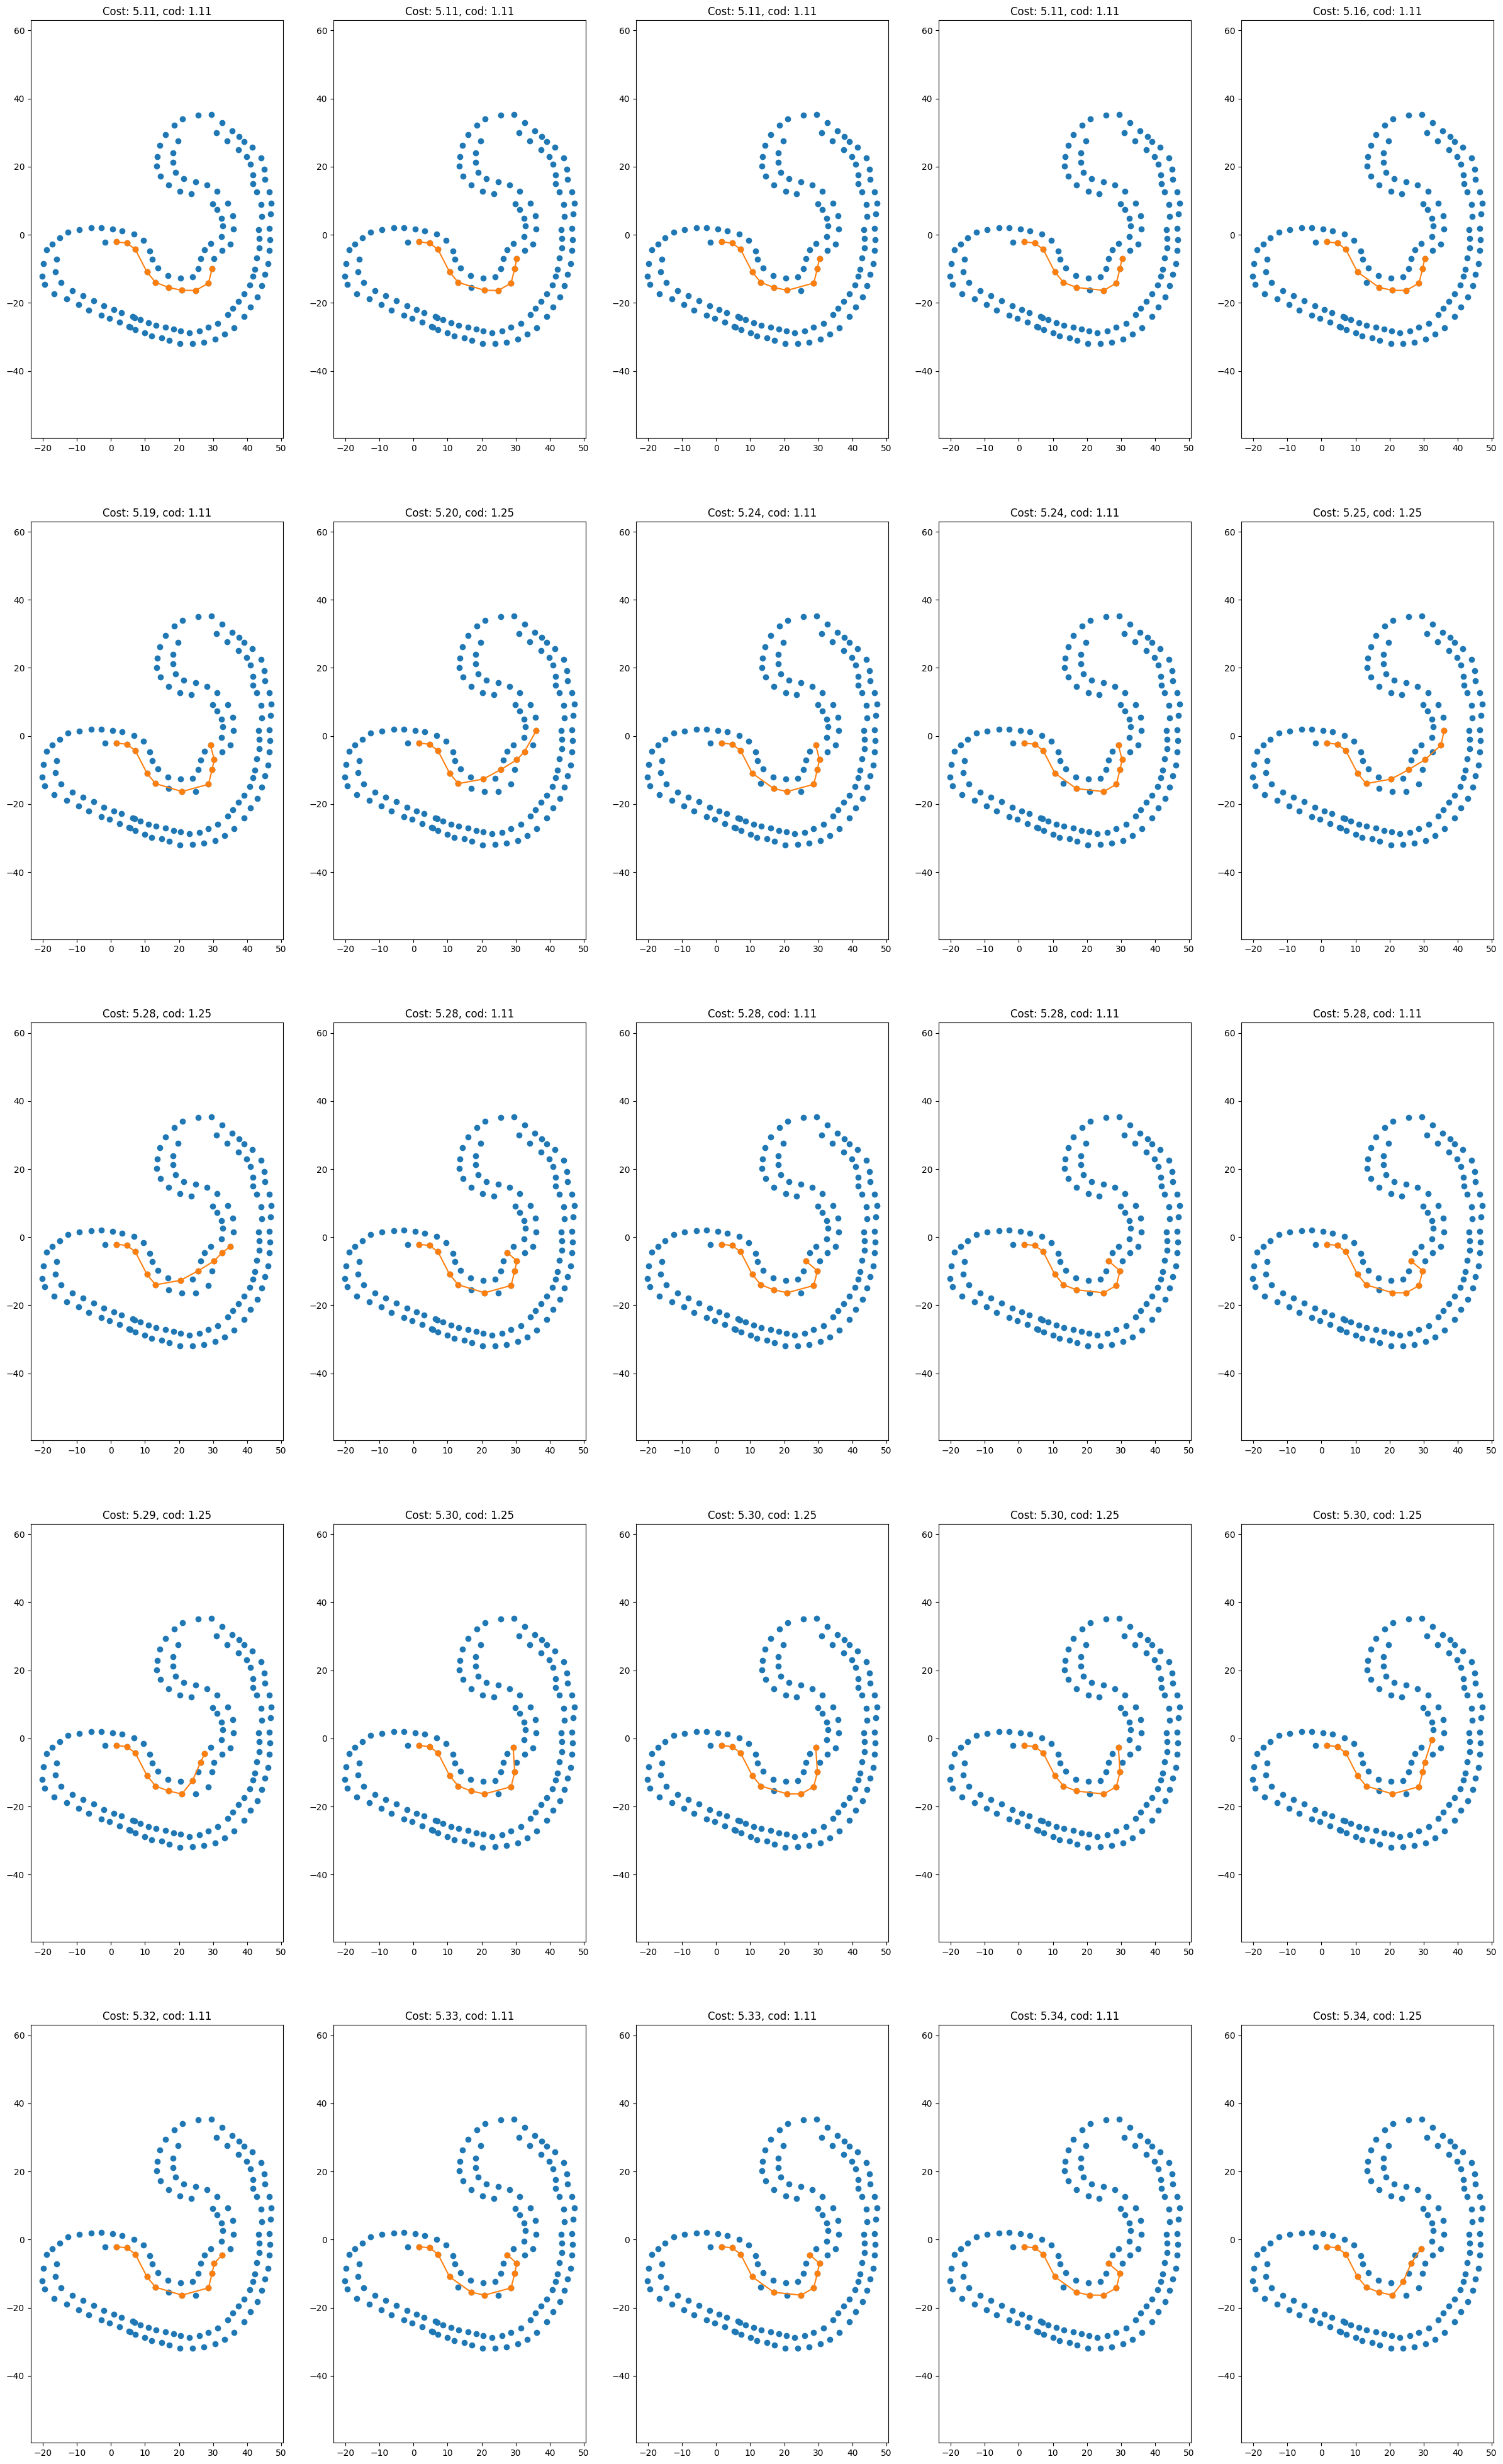

In [233]:
cost_sort_idx = np.argsort(costs)

costs_split_sorted = costs_split[cost_sort_idx]
costs_sorted = costs[cost_sort_idx]
configs_sorted = configs[cost_sort_idx]

n_cols = 5
n_rows = min(len(configs)//5+1, 5)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(30, 50))

axs_flat = axs.flatten()

for i in range(n_rows * n_cols):
    plt.sca(axs_flat[i])

    c = configs_sorted[i]
    c = c[c != -1]
    cost = costs_sorted[i]

    plt.plot(*cones_relative.T, "o")
    plt.plot(*cones_relative[c].T, "o-")
    plt.title(f"Cost: {cost:.2f}, cod: {costs_split_sorted[i][-1]:.2f}")
    plt.axis("equal")
plt.show()

In [143]:
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import calc_change_of_direction_cost


cost_configurations(cones_relative, configs_sorted[:2])

TypeError: cost_configurations() missing 2 required positional arguments: 'cone_type' and 'vehicle_direction'

(-3.0, 19.0, -1.9756574122111383, 1.9249538586798602)

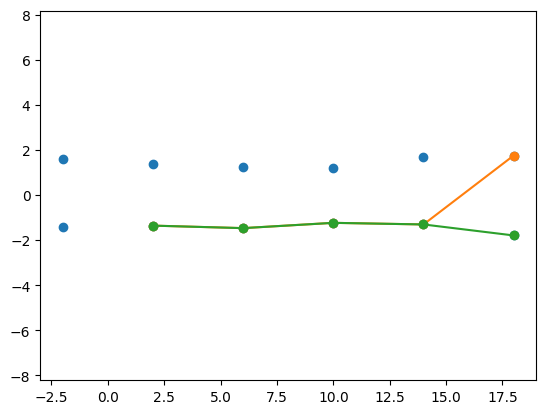

In [ ]:
config_correct = configs_sorted[1][:]
config_correct = config_correct[config_correct != -1]
config_wrong = configs_sorted[0][:]
config_wrong = config_wrong[config_wrong != -1]

plt.plot(*cones_relative.T, "o")
plt.plot(*cones_relative[config_correct].T, "o-")
plt.plot(*cones_relative[config_wrong].T, "o-")
plt.axis("equal")

[0.         0.         0.         0.         0.14858404 0.
 0.        ]
[0.         0.         0.         0.         0.14858404 0.
 0.        ]
0.14858403698864464 0.14858403698864464


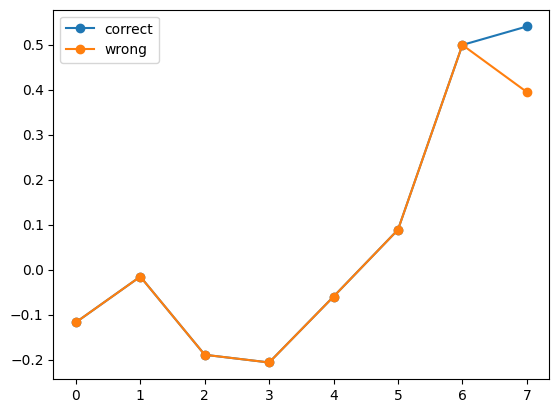

In [29]:
from fsd_path_planning.calculate_path.path_parameterization import angle_difference

d1 = np.diff(cones_relative[config_correct], 1, axis=0)
d2 = np.diff(cones_relative[config_wrong], 1, axis=0)

angles_1 = angle_from_2d_vector(d1)
angles_2 = angle_from_2d_vector(d2)

angles_1_diff = angle_difference(angles_1[:-1], angles_1[1:])
angles_2_diff = angle_difference(angles_2[:-1], angles_2[1:])

sum1 = np.abs(angles_1_diff[:-1] - angles_1_diff[1:]) * (np.sign(angles_1_diff[:-1]) != np.sign(angles_1_diff[1:]))
sum2 = np.abs(angles_2_diff[:-1] - angles_2_diff[1:]) * (np.sign(angles_2_diff[:-1]) != np.sign(angles_2_diff[1:]))

print(sum1, sum2, sep='\n')
print(np.sum(sum1), np.sum(sum2))
    

plt.plot(angles_1_diff, "o-", label="correct")
plt.plot(angles_2_diff, "o-", label="wrong")
plt.legend()


In [71]:
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import calc_cross_appearance_cost

a = np.array([[1,2,3], [7,2,6], [10,11,12]])
b = np.array([[4,5,-1],[4,5,1]])

print(calc_cross_appearance_cost(a, b))

(array([1., 0., 0.]), array([0., 1.]))
